In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.utils import shuffle

from keras.models import Sequential
from keras.layers import InputLayer, LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.constraints import MaxNorm
from keras.callbacks import ModelCheckpoint

In [2]:
filepath = 'C:/Users/ss230/Documents/Study/NSIDC/Edited Data/N_Sea_Ice_Index_Regional_Monthly_Data_G02135_v3.0.xlsx'
Barents = pd.read_excel(filepath, sheet_name='Barents-Extent-km^2')

In [3]:
import sys
sys.path.append('C:/Users/ss230/Documents/Study/NSIDC/NH/')
import Function as fp

In [4]:
fp.month_mapping(Barents)
fp.date_time(Barents)

Extent       Date
0    1107873.946 1979-01-01
1    1211101.473 1979-02-01
2    1215128.770 1979-03-01
3    1233940.811 1979-04-01
4    1193061.566 1979-05-01
..           ...        ...
533   124025.343 2023-06-01
534    53107.426 2023-07-01
535    11242.827 2023-08-01
536     3272.024 2023-09-01
537    35079.225 2023-10-01

[538 rows x 2 columns]

In [5]:
scaler = MinMaxScaler()
Barents['Extent'] = scaler.fit_transform(Barents['Extent'].values.reshape(-1, 1))

In [6]:
def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    lead_time = 8
    for i in range(len(df_as_np) - window_size - lead_time + 1):
        window_data = df_as_np[i:i+window_size]
        row = [[a] for a in window_data]
        X.append(row)
        label = df_as_np[i+window_size+lead_time-1]
        y.append(label)
    return np.array(X), np.array(y)

In [7]:
extent = Barents['Extent']
W_S=12
X,y = df_to_X_y(extent, W_S)
X.shape, y.shape

((519, 12, 1), (519,))

In [8]:
X_train, y_train = X[:420], y[:420]
X_val, y_val = X[420:472], y[420:472]
X_test, y_test = X[472:], y[472:]

In [9]:
model = Sequential()
model.add(InputLayer((W_S, 1)))
model.add(LSTM(128, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(64, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32, activation='relu', kernel_constraint=MaxNorm(1.0)))
model.add(Dense(1, activation='linear'))

cp = ModelCheckpoint('Barents_model_LT8/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(0.0001), metrics=[RootMeanSquaredError()])

In [10]:
import time

stime = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=8, callbacks=[cp])
etime = time.time()

Epoch 1/50
53/53 [==============================] - 22s 251ms/step - loss: 0.1789 - root_mean_squared_error: 0.4229 - val_loss: 0.0404 - val_root_mean_squared_error: 0.2011
Epoch 2/50
53/53 [==============================] - 2s 30ms/step - loss: 0.0940 - root_mean_squared_error: 0.3067 - val_loss: 0.0476 - val_root_mean_squared_error: 0.2183
Epoch 3/50
53/53 [==============================] - 2s 30ms/step - loss: 0.0734 - root_mean_squared_error: 0.2709 - val_loss: 0.0454 - val_root_mean_squared_error: 0.2130
Epoch 4/50
53/53 [==============================] - 2s 30ms/step - loss: 0.0666 - root_mean_squared_error: 0.2581 - val_loss: 0.0473 - val_root_mean_squared_error: 0.2174
Epoch 5/50
53/53 [==============================] - 2s 30ms/step - loss: 0.0593 - root_mean_squared_error: 0.2434 - val_loss: 0.0547 - val_root_mean_squared_error: 0.2340
Epoch 6/50
53/53 [==============================] - 2s 30ms/step - loss: 0.0517 - root_mean_squared_error: 0.2273 - val_loss: 0.0434 - val_root

53/53 [==============================] - 16s 314ms/step - loss: 0.0161 - root_mean_squared_error: 0.1270 - val_loss: 0.0110 - val_root_mean_squared_error: 0.1048
Epoch 38/50
53/53 [==============================] - 2s 33ms/step - loss: 0.0163 - root_mean_squared_error: 0.1277 - val_loss: 0.0110 - val_root_mean_squared_error: 0.1050
Epoch 39/50
53/53 [==============================] - 2s 34ms/step - loss: 0.0163 - root_mean_squared_error: 0.1279 - val_loss: 0.0122 - val_root_mean_squared_error: 0.1105
Epoch 40/50
53/53 [==============================] - 2s 33ms/step - loss: 0.0163 - root_mean_squared_error: 0.1277 - val_loss: 0.0132 - val_root_mean_squared_error: 0.1151
Epoch 41/50
53/53 [==============================] - 2s 32ms/step - loss: 0.0152 - root_mean_squared_error: 0.1233 - val_loss: 0.0159 - val_root_mean_squared_error: 0.1260
Epoch 42/50
53/53 [==============================] - 2s 32ms/step - loss: 0.0151 - root_mean_squared_error: 0.1231 - val_loss: 0.0150 - val_root_mean_

In [11]:
time = (etime - stime)/60
print(f'{time} minutes')

4.385991764068604 minutes


In [12]:
loss = history.history['loss']
epochs = list(range(1, len(loss) + 1))

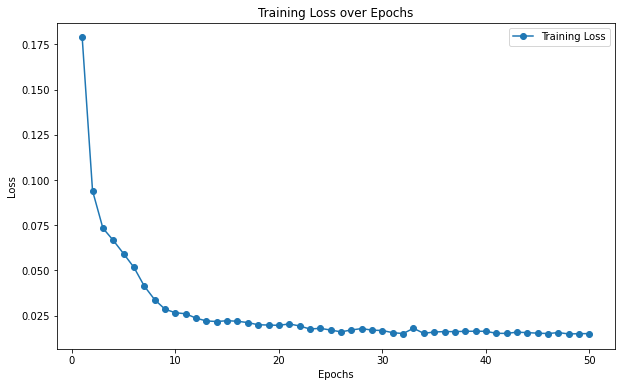

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Training Loss', marker='o', linestyle='-')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

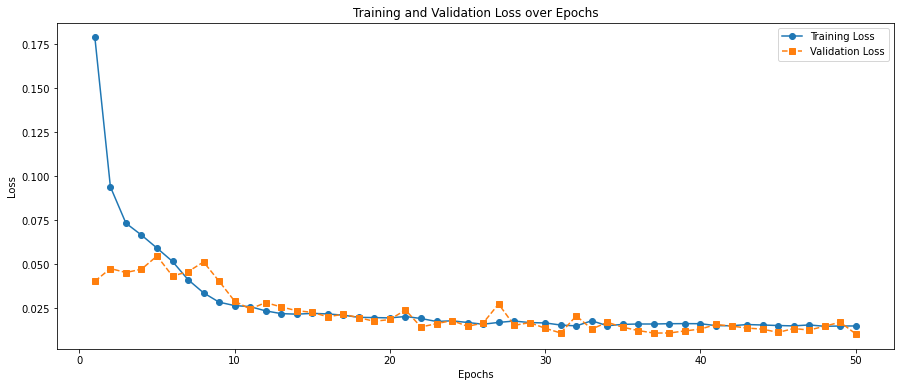

In [14]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(15,6))
plt.plot(epochs, training_loss, label='Training Loss', marker='o', linestyle='-')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='s', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [15]:
from tensorflow.keras.models import load_model
model1 = load_model('Barents_model_LT8/')

In [16]:
test_predictions = model1.predict(X_test)

2/2 [==============================] - 1s 24ms/step


In [17]:
mse = mean_squared_error(y_test, test_predictions)
print('RMSE :', np.sqrt(mse))

mae = mean_absolute_error(y_test, test_predictions)
print('MAE :', mae)

RMSE : 0.10331203771339144
MAE : 0.0839301386886077


In [18]:
test_predictions = scaler.inverse_transform(test_predictions)
test_original = scaler.inverse_transform(y_test.reshape(-1,1))

In [19]:
train_results = pd.DataFrame(data={'Train Predictions': test_predictions.flatten(), 'Actual Extent': test_original.flatten()})
train_results

Train Predictions  Actual Extent
0       306255.937500     406860.687
1       456106.218750     605897.837
2       559028.187500     654073.790
3       589561.437500     701143.910
4       552406.937500     657891.340
5       465229.312500     432215.421
6       342075.500000     201834.787
7       208468.484375      55041.511
8        84575.156250       5387.468
9        67667.351562       1576.813
10      139406.078125      21681.895
11      274681.562500      37772.681
12      427325.156250     239568.531
13      573629.562500     427703.330
14      654228.250000     753043.012
15      649162.437500     764554.603
16      570399.937500     563799.961
17      443129.656250     444109.886
18      285295.687500     189669.492
19      128770.656250      63664.521
20       30016.722656       5984.539
21        7115.660156       1192.062
22       51356.445312      25987.740
23      173237.359375     227374.130
24      333234.156250     498316.637
25      485257.343750     666292.874
26      582128.375000     673348.837
27      601074.437500     635756.948
28      546489.312500     673503.693
29      440095.531250     550922.786
30      308394.250000     116554.569
31      158729.125000      12012.356
32       45282.210938       5446.433
33       40607.410156       2183.701
34      135180.437500      31883.576
35      283961.093750      98802.296
36      449247.156250     224779.107
37      595832.000000     287476.263
38      668708.375000     376683.928
39      657799.687500     571055.966
40      577495.437500     581039.946
41      446941.562500     376525.530
42      276883.093750     124025.343
43      113426.101562      53107.426
44       27093.750000      11242.827
45       -2014.334351       3272.024
46       22000.705078      35079.225

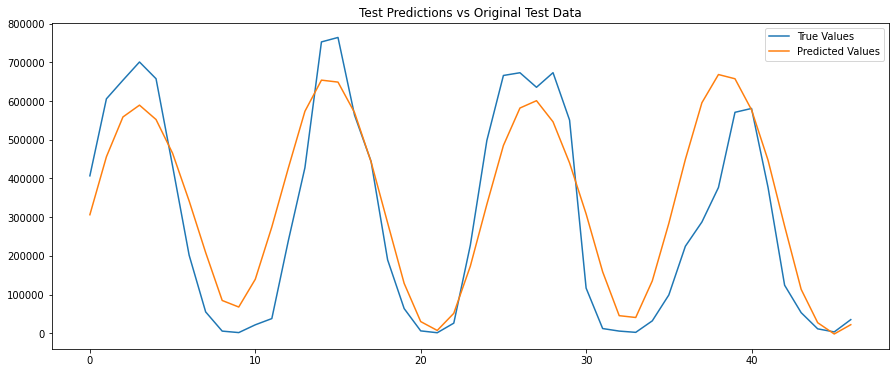

In [20]:
plt.figure(figsize=(15,6))
plt.plot(test_original, label='True Values')
plt.plot(test_predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()

In [21]:
predictions = model1.predict(X)

17/17 [==============================] - 0s 16ms/step


In [22]:
predictions = scaler.inverse_transform(predictions)
Original = scaler.inverse_transform(y.reshape(-1,1))

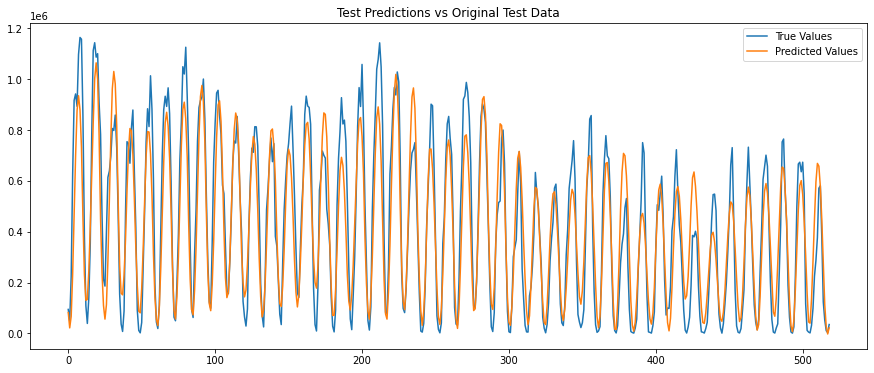

In [23]:
plt.figure(figsize=(15,6))
plt.plot(Original, label='True Values')
plt.plot(predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()